# Computer Vision Generator
---

> Konstantinos Mpouros <br>
> Github: https://github.com/konstantinosmpouros <br>
> Year: 2023 <br>

## 1. About the project

The **Computer Vision Generator** project is designed to explore the capabilities of large language models (LLMs) in the field of image and video generation. The goal of this notebook (**Image Refiner**) is to create a script that refines the image either by adding something in it or by manipulating it and creating a new image similar to first. This process will be conducted with the use of pretrained models for image processing from [huggingface](https://huggingface.co/).

By leveraging the power of LLMs, specifically trained for image synthesis, the script interprets natural language prompts and translates them into detailed, accurate images. This project showcases the potential of AI to bridge the gap between language and vision, enabling the seamless conversion of ideas into visuals. The use cases for such a system are vast, ranging from creative arts and media production to education and design. By automating the process of image creation based on descriptions, the **Computer Vision Generator** opens up new possibilities for users to bring their ideas to life quickly and efficiently.

## 2. Libraries

In [1]:
# Image retrieval and manipulation
from PIL import Image
import os

# Custom mask generation from image
from Mask_Generator import MaskGeneration

# Pytorch
import torch

# Image Upscaler
from aura_sr import AuraSR
from diffusers import FluxPipeline
# from diffusers import FluxControlNetModel
# from diffusers.pipelines import FluxControlNetPipeline

# Image Inpainting
from diffusers import AutoPipelineForInpainting, DEISMultistepScheduler
from diffusers import DiffusionPipeline

2024-10-06 17:06:03.642704: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-06 17:06:03.897799: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-06 17:06:03.897834: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-06 17:06:03.940587: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-06 17:06:04.027764: I tensorflow/core/platform/cpu_feature_guar

In [2]:
def count_files(path):
    # List all files in the directory
    files = os.listdir(path)
    max_number = 0

    # Filter for files that have a .png extension and start with a number
    image_files = [f for f in files if f.endswith('.png')]

    if image_files:
        max_number = len(image_files)

    return max_number

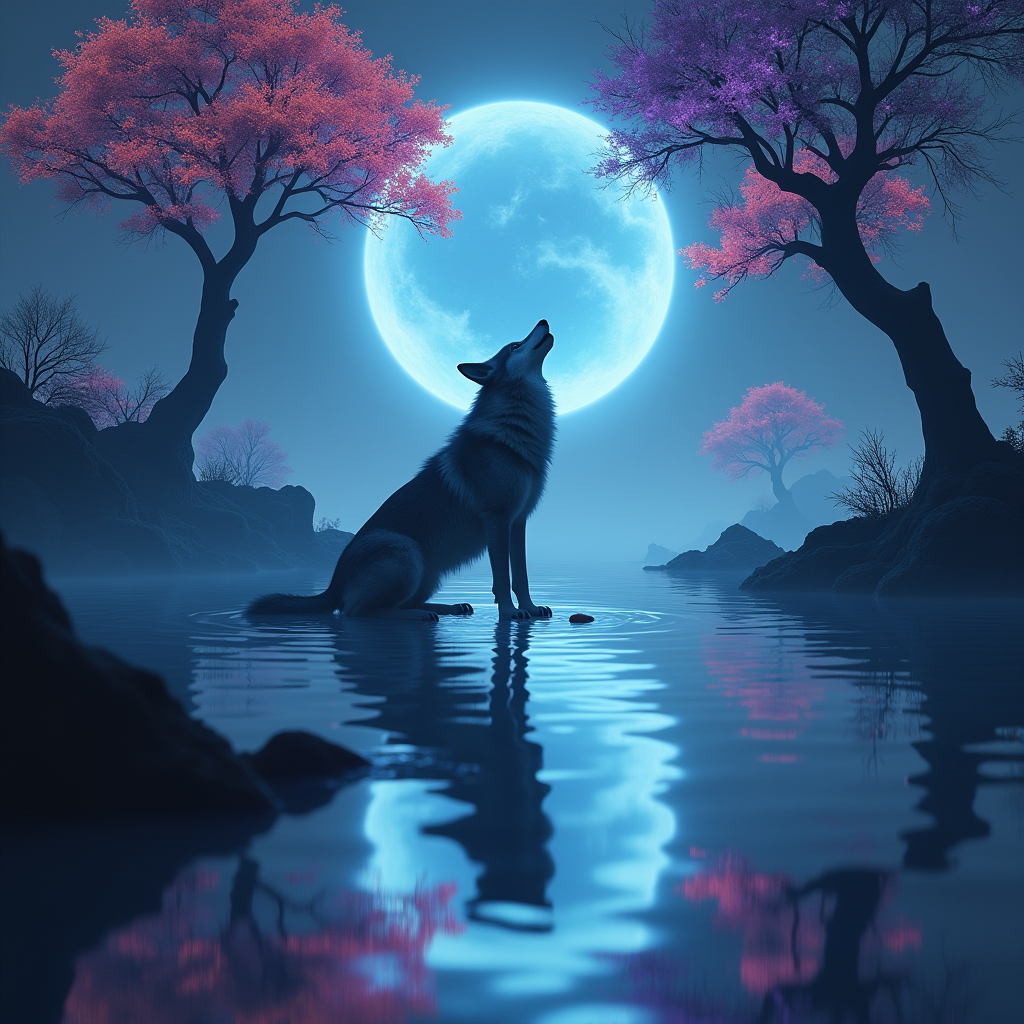

In [3]:
image_name = 'Dreamscape_wolf_3'
init_image = Image.open(f'Image Generation/FLUX.1/{image_name}.png')
init_image

## 3. Image Upscaling

### 3.1 AuraSR V2

In [4]:
aura_sr = AuraSR.from_pretrained("fal/AuraSR-v2")

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

In [5]:
upscaled_image = aura_sr.upscale_4x_overlapped(init_image)
upscaled_image.size

(4096, 4096)

In [6]:
upscaled_image.save(f'Image Refining/Upscaling/AuraSR V2/{image_name}.png')

### 3.2 Flux.1 Controlnet

In [8]:
# from diffusers import FluxControlNetModel
# from diffusers.pipelines import FluxControlNetPipeline

# controlnet = FluxControlNetModel.from_pretrained(
#   "jasperai/Flux.1-dev-Controlnet-Upscaler",
#   torch_dtype=torch.bfloat16
# )

# pipe = FluxControlNetPipeline.from_pretrained(
#   "black-forest-labs/FLUX.1-dev",
#   controlnet=controlnet,
#   torch_dtype=torch.bfloat16
# )

# pipe.to("cuda")

### 3.3 RealESRGAN

## 4. Image Binary Mask and Background Removal

## 5. Image Inpainting

### 5.1 Kandinsky 2

In [8]:
mask_gen = MaskGeneration(init_image)

In [9]:
mask_gen.generate_mask()

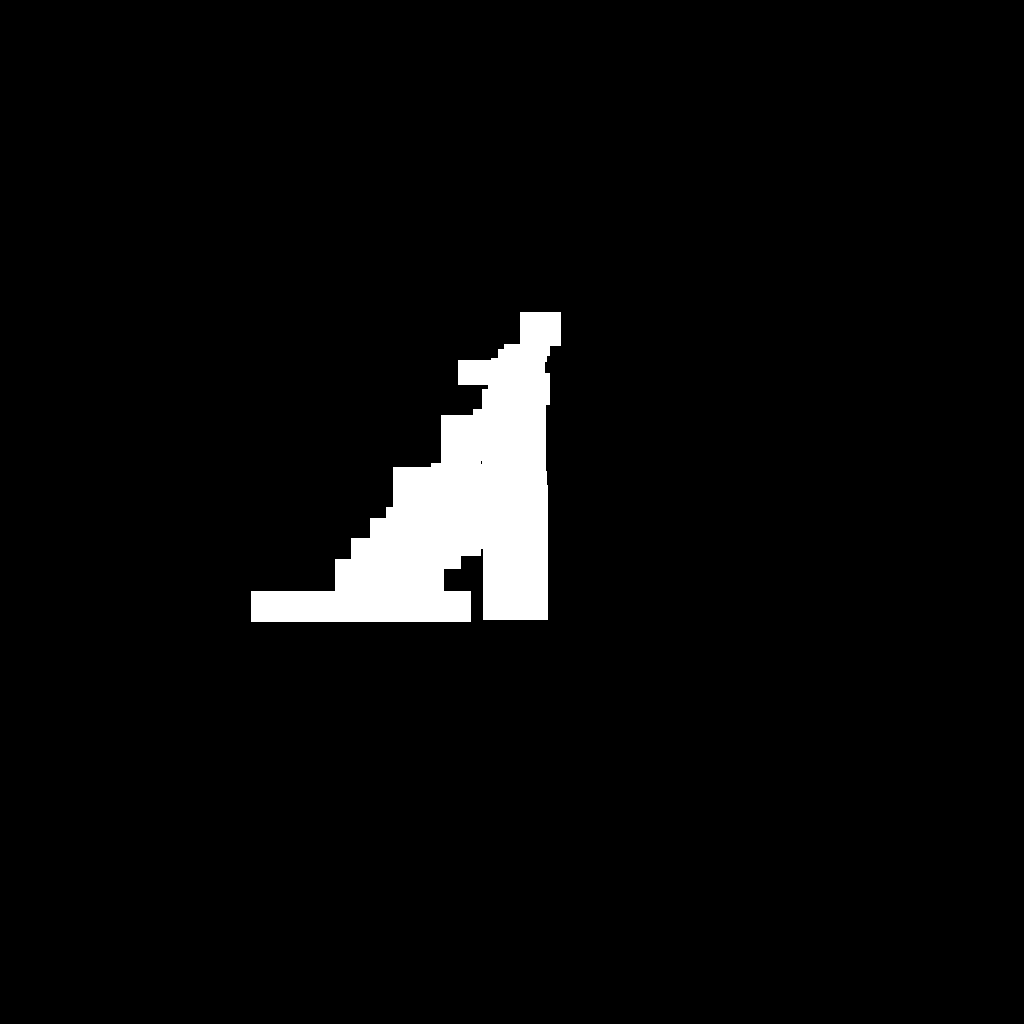

In [10]:
mask = mask_gen.mask
mask

In [11]:
pipe = AutoPipelineForInpainting.from_pretrained("kandinsky-community/kandinsky-2-2-decoder-inpaint", torch_dtype=torch.float16).to('cuda')
# pipe.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/home/konstantinosmpouros/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [12]:
prompt = "A white wolf sitting and howling"

In [13]:
image = pipe(
    prompt=prompt,
    image=init_image,
    mask_image=mask,
    height=768,
    width=768,
    num_inference_steps=650,
    guidance_scale=5
).images[0]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/650 [00:00<?, ?it/s]

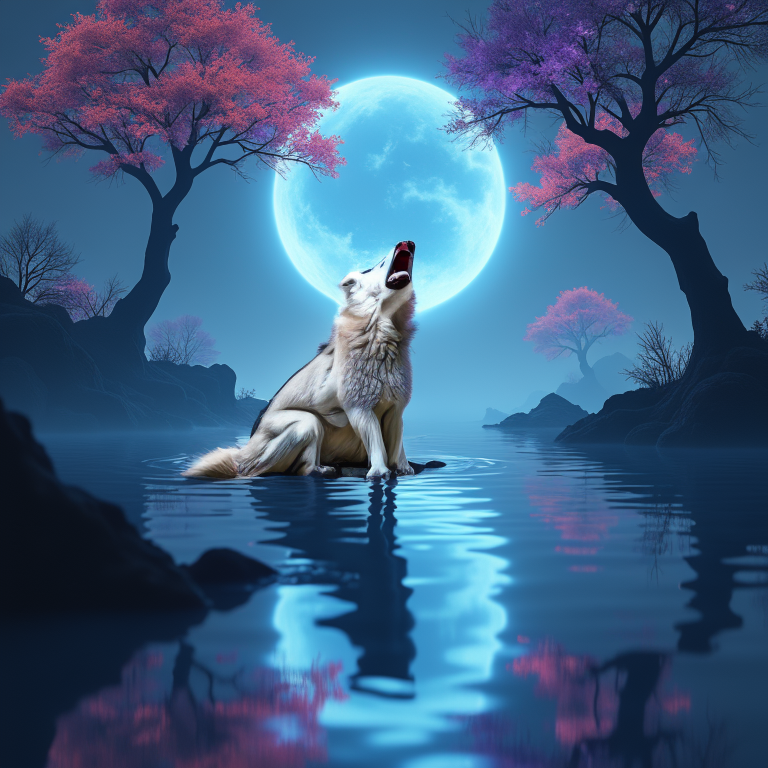

In [14]:
image

In [15]:
max_number = count_files('Image Refining/Inpainting/Kandinsky 2/')

image.save(f'Image Refining/Inpainting/Kandinsky 2/{image_name}_{max_number}.png')

### 5.2 Dreamshaper 8

In [16]:
pipe = AutoPipelineForInpainting.from_pretrained('Lykon/dreamshaper-8-inpainting', torch_dtype=torch.float16, variant="fp16")
pipe.scheduler = DEISMultistepScheduler.from_config(pipe.scheduler.config)
pipe.to('cuda')

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/home/konstantinosmpouros/.local/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


StableDiffusionInpaintPipeline {
  "_class_name": "StableDiffusionInpaintPipeline",
  "_diffusers_version": "0.30.3",
  "_name_or_path": "Lykon/dreamshaper-8-inpainting",
  "feature_extractor": [
    "transformers",
    "CLIPFeatureExtractor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "DEISMultistepScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [18]:
mask_gen = MaskGeneration(init_image)

In [68]:
mask_gen.generate_mask()

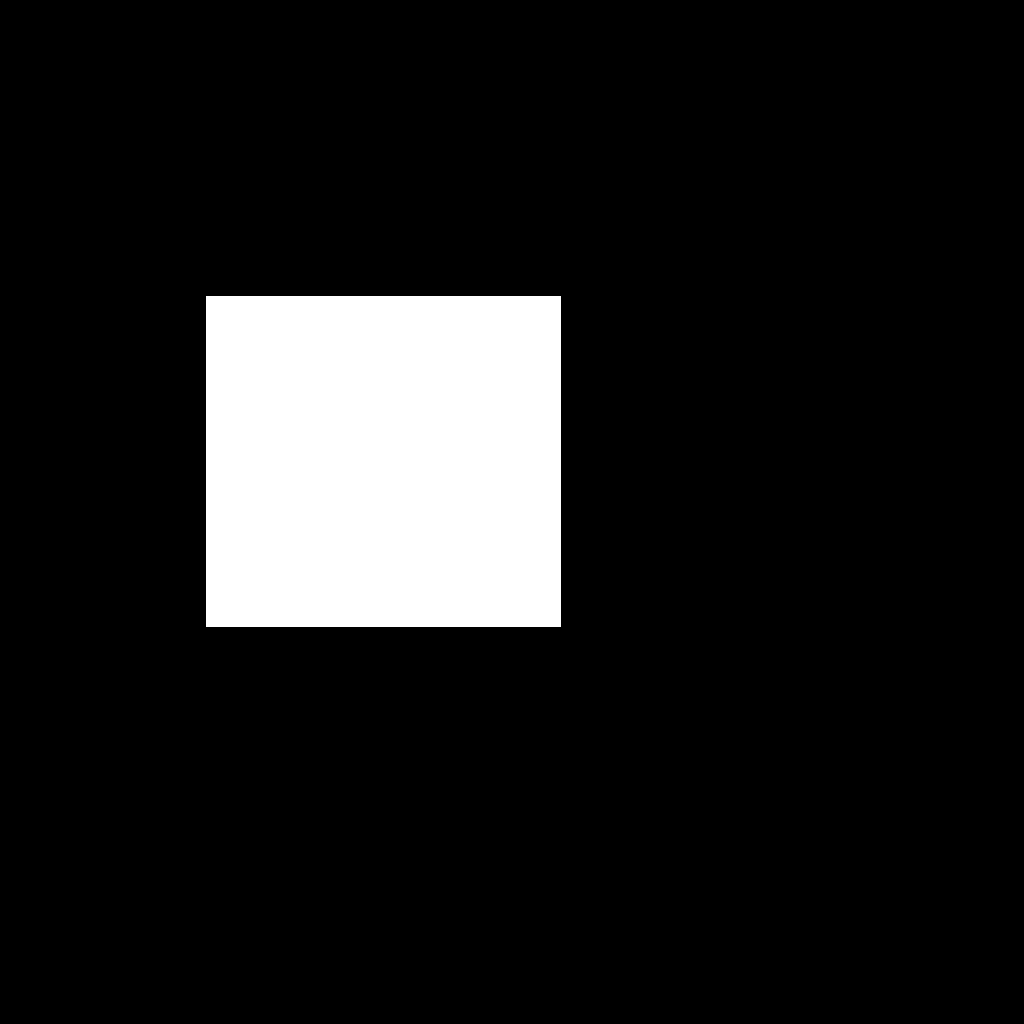

In [69]:
mask = mask_gen.mask
mask

In [84]:
prompt = "A white fox sitting in the water"
# prompt = ""
# prompt = ""
# prompt = ""
# prompt = ""

In [87]:
image = pipe(
    prompt=prompt,
    image=init_image,
    mask_image=mask,
    num_inference_steps=200,
    guidance_scale=2,
    clip_skip=0
).images[0]

  0%|          | 0/200 [00:00<?, ?it/s]

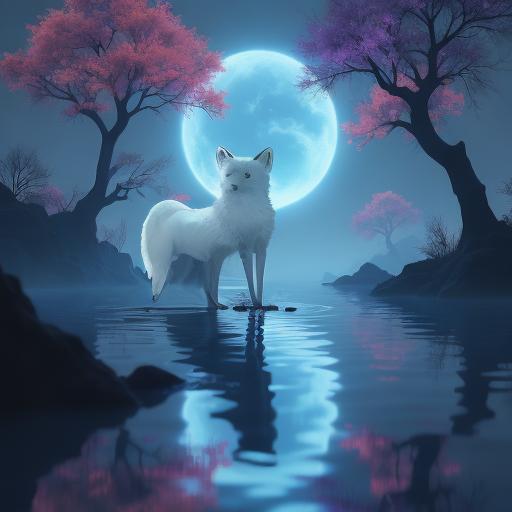

In [88]:
image

In [31]:
max_number = count_files('Image Refining/Inpainting/DreamShaper 8/')
image.save(f'Image Refining/Inpainting/DreamShaper 8/{image_name}_{max_number}.png')

### 5.3 FLUX.1 Controlnet Alpha

In [4]:
pipe = DiffusionPipeline.from_pretrained("alimama-creative/FLUX.1-dev-Controlnet-Inpainting-Alpha")

prompt = "Astronaut in a jungle, cold color palette, muted colors, detailed, 8k"
image = pipe(prompt).images[0]

EntryNotFoundError: 404 Client Error. (Request ID: Root=1-67029957-3056ce015554846a2bb07861;167b00c5-4886-440a-bc5a-45ef4a24452a)

Entry Not Found for url: https://huggingface.co/alimama-creative/FLUX.1-dev-Controlnet-Inpainting-Alpha/resolve/main/model_index.json.